# FFT and aliasing

在這裡我們要介紹如何以一個計算 fourier transform 時常見的問題 - aliasing.

In [1]:
using FFTW
using LinearAlgebra
using Plots

## Section 1

假如我們只在 $[0, 2\pi]$ 區間取樣八個點, 並試著以這八個點找出 $\sin(x) + \sin(9x)$ 的傅立葉係數. 

理論上應該要有四個非零的傅立葉係數, 分別在 $k=\pm1$ 以及 $k=\pm 3$, 但是會發現電腦只算出兩個非零的傅立葉係數, 如下圖, 這是為什麼呢?

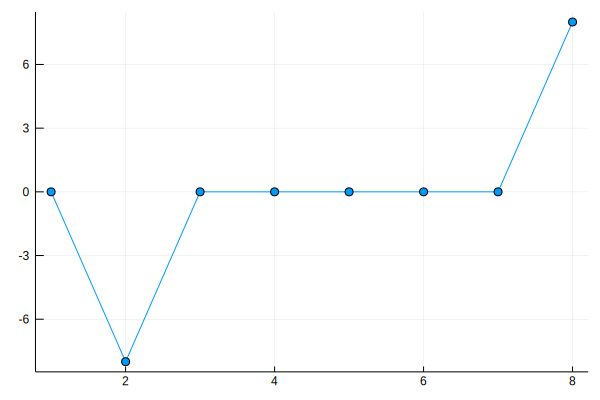

In [2]:
N=8;
x = range(0,stop=2*pi,length=N+1);
x = x[1:N];
fss = sin.(x)+sin.(9*x);
fss_hat = fft(fss);
plot(imag(fss_hat), marker=:circle, leg=false)

我們將 $\sin(x)$ 與 $\sin(9x)$的圖形在取樣八個點時所取到的點分別以 + 跟 x 標示出來, 如下圖左. 可以明顯地看到兩者完全沒有差別. 簡單觀察發現, $\sin(9x)$ 的週期是 $2\pi / 9$，因此 x 只取 8 個點對他來說太少了，沒辦法準確畫出函數。

我們從三角函數的週期性來看：
當 N = 8，$\Delta x = 2 \pi/8$，$x \in [0, 2\pi)$ 則
$$\sin(9x_i) = \sin(9 i \frac{2 \pi}{8}) = \sin(i \frac{18 \pi}{8}) = \sin(i \frac{18-16}{8} \pi) = \sin(i \frac{4 \pi}{8}) = \sin(x_i),~~ i = 0,1,...,N-1$$

在這樣的取點下，$\sin(9x) = \sin(x)$。

下圖右顯示兩個函數以及取點位置, 我們取到的資料沒辦法描述 $\sin(9x)$ 中高頻率的部分. 因此, 當我們在取點時已經將 $\sin(x)+\sin(9x)$ 誤認為 $2\sin(x)$, 所以在算傅立葉係數時就會得到 $y = 2 \sin(x)$ 的傅立葉係數.

這就是所謂的 **aliasing**, 對連續函數做取樣時若取樣數不夠, 就會發生這樣失真的行為. 

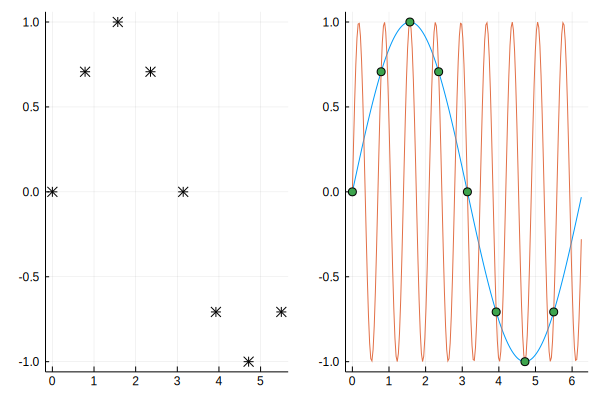

In [3]:
N=8;
x = range(0,stop=2*pi,length=N+1);
x = x[1:N];
f1 = sin.(x);
f9 = sin.(9*x);
p1 = plot(x,f1,seriestype=:scatter,marker=:x,label="sin(x)");
plot!(p1,x,f9,seriestype=:scatter,marker=:+,label="sin(9x)");
NN=200;
xx = range(0,stop=2*pi,length=NN+1);
xx = xx[1:NN];
g1 = sin.(xx);
g9 = sin.(9*xx);
p2=plot(xx,g1);
plot!(p2, xx,g9);
plot!(p2, x, f1,seriestype=:scatter, marker=:circle);
plot(p1,p2,layout=(1,2),legend=false)

## Section 2 - De-aliasing

失真的問題不只發生在取樣時. 即使我們取樣沒問題, 但是在做一些非線性計算時一樣會產生高頻的資料, 而這些資料就會造成我們在做非線性運算後的結果失真. 

如下例: 

假設 $f(x)=\sin(3x)$, 則 $f^2(x) = \sin^2(3x) = \frac{1}{2} - \frac{\cos(6x)}{2}$.

所以雖然對 $f$ 而言最高的頻率只到 $3$, 但是對 $f^2$ 而言最高頻率卻是 $6$. 所以若我們只用八個點取樣 (最高頻率 $4$), 那這樣算 $f^2$ 時就無法正確的反應高頻的部分, 這樣就會造成失真.

* 下圖左上就是我們以 $8$ 個取樣點算 $f$, 下圖右上是做 FFT 後的結果. 可以發現沒有問題.
* 下圖左下是我們以 $8$ 個取樣點算 $f^2$, 下圖右下是做 FFT 後的結果. 可以發現是不對的.

**NOTE:** 這邊要特別提一下, 在取樣點所算出來的函數值(value)是正確的, 不過頻率(frequency)是錯的. 所以如果只是要做函數值的運算是沒有問題的, 不過如果需要用頻率來做運算, 比如說求微分, 那就會出問題了.

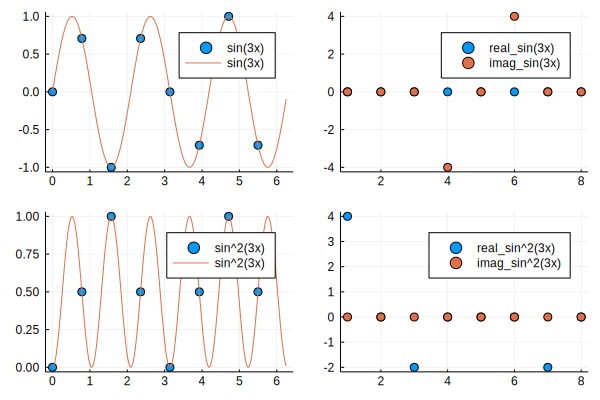

In [4]:
## sampling at 8 points
N = 8;
x = range(0,stop=2*pi,length=N+1);
x = x[1:N];

## get the fourier coefficients as _hat
f1 = sin.(3*x);
f2 = f1.^2;
f1_hat = fft(f1);
f2_hat = fft(f2);

## plotting
NN = 200;
xx = range(0,stop=2*pi,length=NN+1);
xx = xx[1:NN];
g1 = sin.(3*xx);
g2 = g1.^2;

p1 = plot(x,f1,seriestype=:scatter,marker=:circle,label="sin(3x)");
plot!(p1,xx,g1,label="sin(3x)");

p3 = plot(x,f2,seriestype=:scatter,marker=:circle,label="sin^2(3x)");
plot!(p3,xx,g2,label="sin^2(3x)");

p2=plot(real(f1_hat),seriestype=:scatter,marker=:circle,label="real_sin(3x)");
plot!(p2, imag(f1_hat),seriestype=:scatter,marker=:circle,label="imag_sin(3x)");
p4=plot(real(f2_hat),seriestype=:scatter,marker=:circle,label="real_sin^2(3x)");
plot!(p4, imag(f2_hat),seriestype=:scatter,marker=:circle,label="imag_sin^2(3x)");
plot(p1,p2,p3,p4,layout=(2,2))

## Section 3 - Interpolation

在討論如何解決失真問題之前我們先討論傅立葉 interpolation(差值) 問題. 

我們知道一個週期為 $L$ 的函數可寫成三角函數的展開
$$
f(x) = \sum^{\infty}_{k=-\infty} \hat{f}_k e^{\frac{2\pi i}{L}kx},
$$
其中 $\hat{f}_k$ 稱之為傅立葉係數 (fourier coefficients). 要注意的是這是一個**連續的**描述, 也就是說任意給定 $x$ 我們都可以用以上這個公式把 $f(x)$ 算出來. 

換句話說, 假設我們知道一個函數的傅立葉係數, 帶入以上這個公式理論上我們可以把一個函數任何一個點的值準確的算出來.

不過當然, 在計算上我們需要對一個函數做取樣, 所以無法取無窮多點. 一個簡單的觀察是

* 取樣點數 = 傅立葉係數個數

比如說我們對一個函數取樣 $7$ 個點, 那就會有 $k=[0, 1, 2, 3, -3, -2, -1]$ 這些傅立葉係數, 也就是說我們有 $\hat{f}_{-3}, \cdots, \hat{f}_3$. 所以這個函數可以寫成 
$$
f(x) = \sum^{3}_{k=-3} \hat{f}_k e^{\frac{2\pi i}{L}kx}.
$$
理論上若我們要算這個函數在任一點的值, 只需要帶入 $x$ 到以上這函數去求就可以了. 

不過計算上我們通常希望是一開始取樣 $N$ 點, 利用 fourier interpolation 來**快速的**求出取樣 $M$ 點的值, 其中 $M>N$. 關鍵是這些取樣點是均勻取樣. 而做法其實很簡單, 事實上上面的這個函數也可以寫成, 比如說, 
$$
f(x) = \sum^{5}_{k=-5} \hat{f}_k e^{\frac{2\pi i}{L}kx}, 
$$

其中 $\hat{f}_k=0$, $|k|>3$. 這樣我們就有 $f$ 這個函數的 $11$ 個傅立葉係數了. 而就像剛剛我們說的"取樣點數 = 傅立葉係數個數". 我們只要將 $11$ 個傅立葉係數做 ifft, 就可以得到 $f$ 這個函數上取樣 $11$ 點的值.  

* 唯一需要注意的一點是, 一般計算上 fft 的係數會跟取樣點數 $N$ 有關, 所以當將 $7$ 個點加係數成 $11$ 點時, 所有係數要乘以 $\frac{11}{7}$. 

以下舉個例子

1. 我們以 $8$ 個點取樣 $\sin(x)$ 這個函數, 並求得 $8$ 個傅立葉係數
2. 我們接著加兩個零傅立葉係數使得整體係數變成 $10$ 個 
3. 將係數乘以 $\frac{10}{8}$ 再取 ifft, 得到 $\sin(x)$ 取樣 $10$ 點的值
4. 我們與真實 $\sin(x)$ 做比較, 發現非常完美

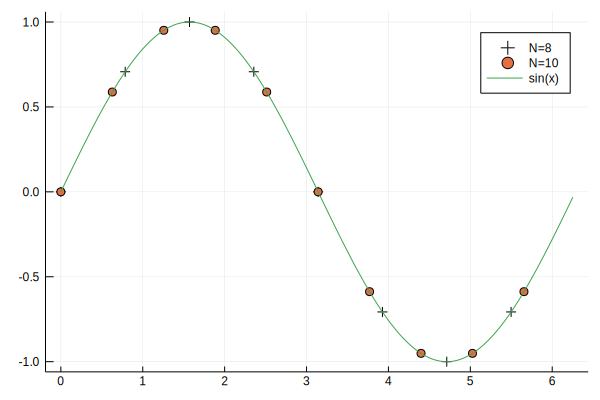

In [5]:
# step 1
N=8;
x = range(0,stop=2*pi,length=N+1);
x = x[1:N];
fs = sin.(x);
fs_hat = fft(fs);
p1 = plot(x, fs, seriestype=:scatter, marker=:+, label="N=8")

# step 2
b = append!(fs_hat[1:4], zeros(2)+zeros(2)*im);
fs2_hat = append!(b,fs_hat[5:8]);

# step 3
fs2_hat = fs2_hat*10.0/8.0;
fs2 = real(ifft(fs2_hat));

N2=10;
x2 = range(0,stop=2*pi,length=N2+1);
x2 = x2[1:N2];
plot!(p1, x2, fs2, seriestype=:scatter, marker=:circle, label="N=10")

# step 4
N3 = 200;
x3 = range(0,stop=2*pi,length=N3+1);
x3 = x3[1:N3];
fs2 = sin.(x3);
plot!(p1, x3, fs2, label="sin(x)")

### Section 2.1 - De-aliasing by adding points

由前面我們知道 aliasing error 的原因就是取點數不足造成失真, 所以一個直覺解決這問題的想法就是, 那就多加些點就好了!!

所以我們就照前面的方式來加點, 以取樣八點算 $\sin^2(3x)$ 為例, 我們知道需要兩倍的點才有辦法找出 $\sin^2(3x)$ 正確的頻率, 所以我們就再加八個點. 

1. 在頻率加八個高頻的零使得有16個函數值的取樣點

接著，將新的傅立葉係數轉回函數 $\sin(3x)$，此時的 $\sin(3x)$ 函數會比原先的 $\sin(3x)$ 多出八個點。轉回去之後再將函數平方，得到 $g(x) = \sin(3x)^2$。

2. 以這16個函數值來算 $\sin^2(3x)$ 以及其傅立葉係數. 

可以看到我們完美的得到正確的傅立葉係數了. 

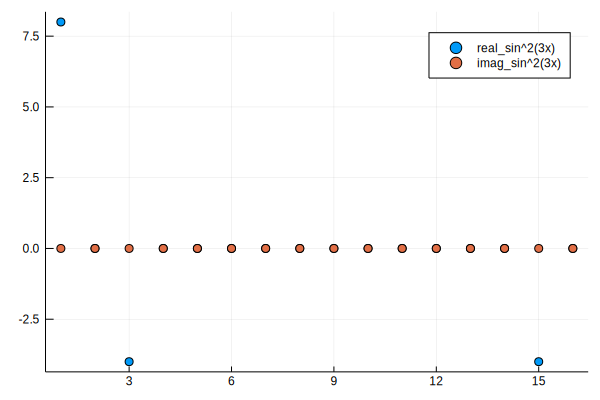

In [6]:
N = 8;
x = range(0,stop=2*pi,length=N+1);
x = x[1:N];
f = sin.(3*x);
f_hat = fft(f)

# 1. adding zeros to obtain 16 sample values
b = append!(fs_hat[1:4], zeros(8)+zeros(8)*im);
fs2_hat = append!(b,fs_hat[5:8]);
fs2_hat = fs2_hat*16.0/8.0;
fs2 = real(ifft(fs2_hat));

# 2. 
g = fs2.^2;
g_hat = fft(g)
p=plot(real(g_hat),seriestype=:scatter,marker=:circle,label="real_sin^2(3x)");
plot!(p, imag(g_hat),seriestype=:scatter,marker=:circle,label="imag_sin^2(3x)")

Zero - padding (3/2 rule) 的詳細推導請參考下列文件 http://www.math.jhu.edu/~feilu/notes/DealiasingFFT.pdf ，這裡我們只簡單說明。

Julia 中，函數 $f(x)$ 的傅立葉係數 fft(f) 為 
$$\hat{f}_{k} = \sum_{j = 1}^{N} e^{-i k x_j} f_j$$ 
其中 $N$ 為 $[0,2\pi)$ 間點的個數。

當我們把 $f(x)$ 平方，$f^2(x)$ 的第 $k$ 個傅立葉係數 
$$ F_N[f^2]_k = \sum_{m+n = k} \hat{f}_m \hat{f}_n  = \sum_{-\frac{N}{2}+1 \leq m,k-m \leq \frac{N}{2}} \hat{f}_m \hat{f}_{k-m} + \sum_{-\frac{N}{2}+1 \leq m \leq \frac{N}{2},~ k-m > \frac{N}{2} ~or~ k-m <-\frac{N}{2}+1} \hat{f}_m \hat{f}_{k-m}$$ 

第二個加總有可能會造成 aliasing. 若 $k - m > N/2 $，則會疊加到 $k - m - N $。若 $k - m < -N/2 $，則會疊加到 $k - m + N $。

zero-padding 是將點數增加為原來的 3/2 倍，我們看 3/2 這個數字怎麼來的。假設我們將點數增加到 K 個, 令 $k, m \in [-N/2+1, N/2]$，並考慮兩個case：

    |---(要增加的部分)---|======================|---(要增加的部分)---|

$-(K-1)/2 ~~~~~~~~~~~~~~~~~ -(N-1)/2 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ N/2 ~~~~~~~~~~~~~~~~~~~~~~~~~~~ K/2$

* case 1.  若 $k - m > N/2 $，則會疊加到 $k - m - N $，我們要使 $[-N/2+1 , N/2]$ 這個區間不會混入疊加後的傅立葉係數。因此要令 $k-m-K < -N/2 +1$。取 $k = N/2$, $m = -N/2 +1$，得 $N-1-K < -N/2 +1$，也就是 $K > \frac{3}{2}N -2$。

* case 2.  若 $k - m < -K/2+1 $，則會疊加到 $k - m + K $，我們要使 $[-N/2+1 , N/2]$ 這個區間不會混入疊加後的傅立葉係數。因此要令 $k-m+K > N/2$。取 $m = N/2$, $k = -N/2 +1$，得 $ -N+1+K > -N/2 $，也就是 $K > \frac{3}{2}N -1$。

因此我們就令 $K = \frac{3}{2}N$。

以下，我們再以 $\sin(3x)^2$ 為例：

我們把  $g(x) = \sin(3x)^2$ 利用倍角公式整理一下，
$$g(x) = \sin(3x)^2 = \frac{1-\cos(6x)}{2}.$$
這會算出$\hat{f}_0$，$\hat{f}_6$ 的傅立葉係數，因此至少會需要令 N = 12。

底下兩張圖，我們分別畫出 $\sin(3x)^2$ 與 $\frac{1-\cos(6x)}{2}$ 的傅立葉係數，結果是一樣的。

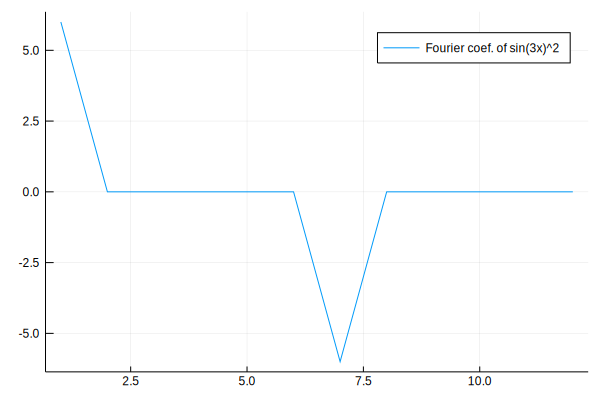

In [7]:
N=8;
x = range(0,stop=2*pi,length=N+1);
x = x[1:N];
f = sin.(3*x);
f_hat = fft(f)

# 1. zeropadding
K = N/2*3;
f_hat_new = zeros(Int(K))+zeros(Int(K))*im;
f_hat_new[1:Int(N/2 +1)] = f_hat[1:Int(N/2 +1)]
f_hat_new[Int(K-N/2+2):Int(K)] = f_hat[Int(N/2+2):Int(N)];
f_hat_new = (K/N)*f_hat_new;

# 2. do ifft，to obtain function sin(3x)
fs = ifft(f_hat_new);
g = fs.^2;

# 3. do fft
g_hat = fft(g)
plot(real(g_hat),label="Fourier coef. of sin(3x)^2")

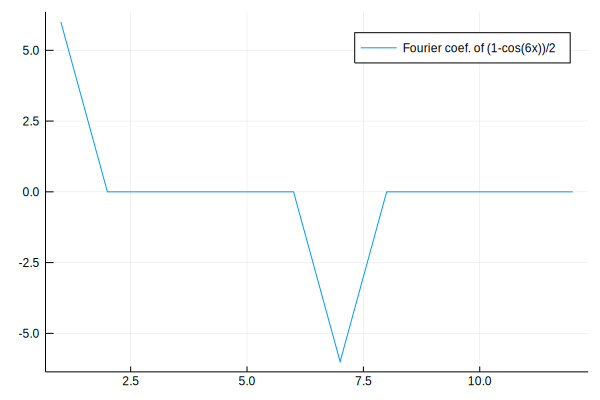

In [8]:
N=12;
x = range(0,stop=2*pi,length=N+1);
x = x[1:N];
f = (ones(N,1)-cos.(6*x))./2;
f_hat = fft(f)
plot(real(f_hat),label="Fourier coef. of (1-cos(6x))/2")

# TS: 以下我還沒動!!!


### Section 2.2 truncating (2/3-rule)
計算函數 $f(x)$ 的平方，當 N 為偶數時，我們令 $${f_1(x)} = \frac{1}{2 \pi} \sum_{j = -N/2 +1}^{N/2} \hat{f}_{j} e^{i j x},~~ {f_2(x)} = \frac{1}{2 \pi} \sum_{s = -N/2 +1}^{N/2} \hat{f}_{s} e^{i s x},$$ 所以 $f^2(x) = f_1(x)f_2(x)$ 就會產生 $\hat{f}_{s+j} e^{i (s+j) x}$ 的高頻率。而 $s+j$ 的頻率會疊加到 $ s+j-N $ 的頻率。

從上面的例子我們知道，當取點數太少時，函數的傅立葉係數沒辦法被準確的取出來，高頻的部分會干擾低頻的部分。因此 truncating 的方法，就是事先把頻率過高的傅立葉係數去掉，留下低頻的部分。

用簡單的例子看看，令 $f(x) = \sin(2x) = \frac{1}{2}(\hat{f}_{2}e^{2i\theta} + \hat{f}_{-2}e^{-2i\theta})$。如果我們取 N = 7，那就可以容納 $\hat{f}_{-3}, \hat{f}_{-2}, \hat{f}_{-1}, \hat{f}_{0}, \hat{f}_{1}, \hat{f}_{2}, \hat{f}_{3}$ 這麼多個傅立葉係數，可以表示 $\sin(2x)$。

但是，如果我們將 $f(x)$ 平方，會得到 $g(x) = f^2(x) = \sin^2(2x) = \frac{1}{4}(\hat{f}_{2}e^{2i\theta} + \hat{f}_{-2}e^{-2i\theta})(\hat{f}_{2}e^{2i\theta} + \hat{f}_{-2}e^{-2i\theta}) = \frac{1}{4}(\hat{g}_{4}e^{(2+2)i\theta} + \hat{g}_{-4}e^{(-2-2)i\theta} + \hat{g}_{0})$。相乘後產生的高頻因為超過可容納的範圍，$\hat{g}_{4}e^{4i\theta}$ 就會疊加到 $\hat{g}_{-3}e^{-3\theta}$，而 $\hat{g}_{-4}e^{-4i\theta}$ 就會疊加到 $\hat{g}_{3}e^{3i\theta}$，我們就會看到錯誤的頻率。

也可以從三角函數週期性的觀點來看，$\sin^2(2x) = \frac{1-\cos(4x)}{2}$，當 N = 7，$\Delta x = 2 \pi/7$，$x \in [0, 2\pi)$ 則
$$\cos(4x_i) = \cos(4 i \frac{2 \pi}{7}) = \cos(i \frac{8 \pi}{7}) = \cos(i \frac{8-14}{7} \pi) = \cos(i \frac{-6 \pi}{7}) = \cos(-3 i \frac{2 \pi}{7}) = \cos(-3 x_i),~~ i = 0,1,...,N-1$$

接著，我們討論要留下多少傅立葉係數。我們分成取點數 N 為奇數和偶數兩種情況討論

1. 當取點數 N 為奇數時，$f(x)$ 會有下列的傅立葉係數

$$\hat{f}_{-(N-1)/2},..., \hat{f}_{-2}, \hat{f}_{-1}, \hat{f}_0, \hat{f}_1, \hat{f}_2, ...\hat{f}_{(N-1)/2}$$.

以 N = 7 為例就是

$$\hat{f}_{-3}, \hat{f}_{-2}, \hat{f}_{-1}, \hat{f}_{0}, \hat{f}_{1}, \hat{f}_{2}, \hat{f}_{3}$$

我們有 $\hat{f}_{1}, \hat{f}_{2}, \hat{f}_{3}$ 也有 $\hat{f}_{-1}, \hat{f}_{-2}, \hat{f}_{-3}$，傅立葉係數剛好有成對。

再回來看 $\cos(4x)$ 的例子，$\cos(4x)$ 會疊加到 $\cos((4-7)x) = \cos(-3x)$，從圖上來看：
$$\hat{f}_{-3}, \hat{f}_{-2}, \hat{f}_{-1}, \hat{f}_{0}, \hat{f}_{1}, \hat{f}_{2}, \hat{f}_{3}, (\hat{f}_{4})$$

$\hat{f}_{4}$ 這一項往左數了 7 個位置(N)，到達 $\hat{f}_{-3}$。





底下我們考慮成對的傅立葉係數就好，$\hat{f}_{0}$ 先忽略。因此令 N' = N-1，考慮以下的傅立葉係數

$$\hat{f}_{-3}, \hat{f}_{-2}, \hat{f}_{-1}, \hat{f}_{1}, \hat{f}_{2}, \hat{f}_{3}$$
在沒有 $\hat{f}_{0}$ 的時候，$\hat{f}_{4}$ 這一項往左數了 6 個位置(N')，就可以到達 $\hat{f}_{-3}$。


    |---(要取零的部分)---|======================|---(要取零的部分)---|

$-(N-1)/2 ~~~~~~~~~~~~~~~~~~~~~~~ -K ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ K ~~~~~~~~~~~~~~~~~~~~~~~~ (N-1)/2$

1. 假設 $j,s \in [1, K]$ 時，函數相乘不會產生疊加 (aliasing) 現象。

2. 計算函數 $f(x)$ 的平方，$f^2(x) = f_1(x)f_2(x)$ 會產生 $\hat{f}_{s+j} e^{i (s+j) x}$ 的高頻率，$\hat{f}_{s} e^{i s x}$ 來自 $f_1(x)$，$\hat{f}_{j} e^{i j x}$ 來自 $f_2(x)$。而 $s+j$ 的頻率會疊加到 $ s+j-N' $ 的頻率。

3. 我們希望 $ s+j-N' $ 這個疊加產生的頻率能落在要取零的區域裡。所以我們令 $ s+j-N' < -K $

4. 取 $j = s = K$，則 $ s+j-N' \leq K + K - N' < -K $，整理不等式 $ K + K - N' < -K $，得到 $ K < N'/3$

所以我們令 $K < \frac{N'}{3} = (\frac{2}{3})(\frac{N'}{2})$

#### Example 1
在這個例子裡，$f(x) = \sin(x)$，$g(x) = f^2(x) = \sin^2(x) = \frac{1}{2} - \frac{1}{2}\cos(2x)$ 的傅立葉係數有 $\hat{g}_{0}$、$\hat{g}_{2}$ 和 $\hat{g}_{-2}$。

如果我們取 N = 7，那就可以容納 $\hat{g}_{-3}, \hat{g}_{-2}, \hat{g}_{-1}, \hat{g}_{0}, \hat{g}_{1}, \hat{g}_{2}, \hat{g}_{3}$ 這麼多個傅立葉係數。而我們算出來的傅立葉係數還在上面的範圍裡，因此算 $\sin(x)$ 的平方，不管有沒有做 truncating 都沒有問題。

這是不做 truncating，直接將函數平方的結果。

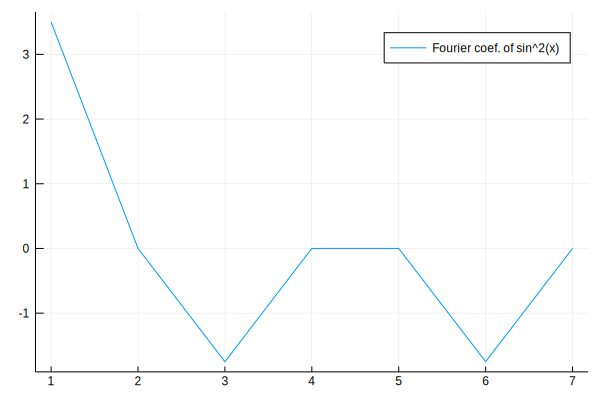

In [9]:
N=7;
x = range(0,stop=2*pi,length=N+1);
x = x[1:N];
f = sin.(x);
f2 = f.^2;
f_hat = fft(f2)
plot(real(f_hat),label="Fourier coef. of sin^2(x)")

這是做 truncating 的結果。
根據上面的推導，取 $K < \frac{N'}{3} = \frac{6}{3} = 2$，我們只保留 $\hat{f}_{-1}, \hat{f}_0, \hat{f}_1$。和我們預測的一樣，這個例子直接平方和做 truncating 的結果相同。

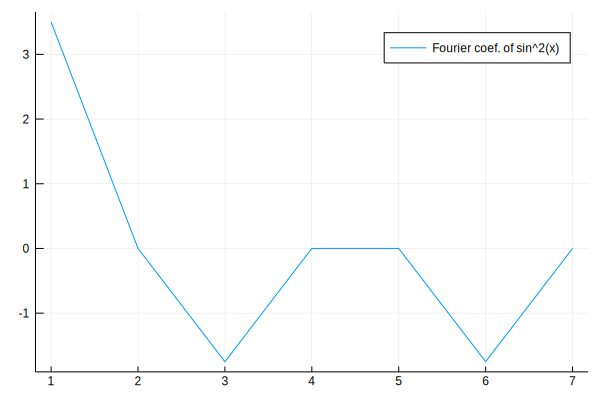

In [10]:
N=7;
x = range(0,stop=2*pi,length=N+1);
x = x[1:N];
f = sin.(x);
f_hat = fft(f)

# 1
f_hat[4] = 0;
f_hat[5] = 0;

# 2
f_new = ifft(f_hat)

# 3
f2 = f_new.^2;
f2_hat = fft(f2)

plot(real(f2_hat),label="Fourier coef. of sin^2(x)")

#### Example 2
令 $f(x) = \sin(2x)$，則 $g(x) = f^2(x) = \sin^2(2x) = \frac{1}{2} - \frac{1}{2}\cos(4x)$，理論上會有 $\hat{g}_{0}$，$\hat{g}_{-4}$，$\hat{g}_{4}$。但我們卻算出 $\hat{g}_{0}$，$\hat{g}_{-3}$，$\hat{g}_{3}$，這是取點數過少產生的 aliasing。

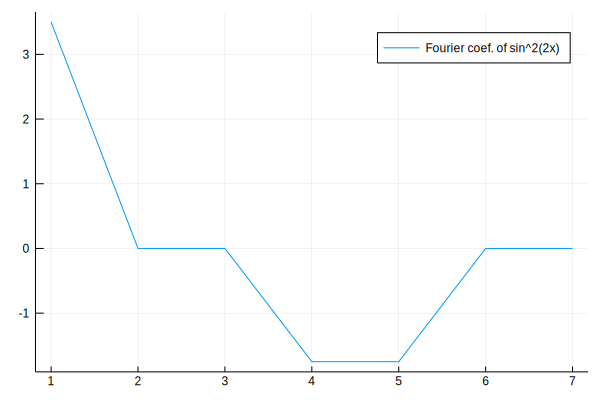

In [11]:
N=7;
x = range(0,stop=2*pi,length=N+1);
x = x[1:N];
f = sin.(2x);
f2 = f.^2;
f_hat = fft(f2)
plot(real(f_hat),label="Fourier coef. of sin^2(2x)")

底下我們用 truncating (2/3-rule) 把錯誤的頻率去除。

當 N = 7，$K < \frac{N'}{3} = \frac{6}{3} = 2$，

所以我們將 $\hat{f}_{2}$，$\hat{f}_{-2}$，$\hat{f}_{3}$，$\hat{f}_{-3}$ 令為零。得到修改後的傅立葉係數 f_hat。

接著我們將傅立葉係數轉回函數 f_new，再將 f_new 平方。

將平方後的函數取傅立葉係數，就會發現 $\hat{g}_{-3}$，$\hat{g}_{3}$ 這兩個不該出現的傅立葉係數消失。但 $\hat{g}_{0}$ 也跟著消失，因為 $\hat{g}_{0}$ 是來自 $\hat{f}_{-2}$ 與 $\hat{f}_{2}$ 相乘。

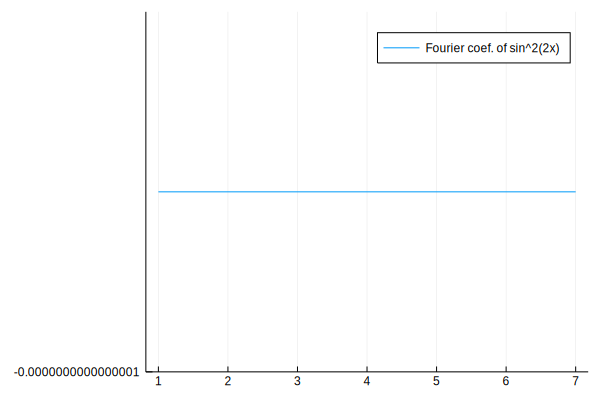

In [12]:
N=7;
x = range(0,stop=2*pi,length=N+1);
x = x[1:N];
f = sin.(2*x);
f_hat = fft(f)

# 1. 把 K 求出來，令新的 K 為小於舊的 K 的整數
K = (N-1)/3;

if K == floor(K)  
    K = Int(K) - 1;       # 若 K 算出來是整數，就取 K-1
else
    K = Int(floor(K));    # 若 K 算出來不是整數，就取 K 的整數部分
end

# 2. 只留下有符合範圍的部分 其餘設成 0
f_hat_new = append!(f_hat[1:K+1], zeros(1, N - 2*K-1));  # 保留 f_har_0, f_hat_1,..., f_hat_K
f_hat_new = append!(f_hat_new,f_hat[N-K+1:N]);           # 保留 f_hat_-K, f_hat_-K+1,..., f_hat_-1

# 3
f_new = ifft(f_hat_new)

# 4
f2 = f_new.^2;
f2_hat = fft(f2)

plot(real(f2_hat),label="Fourier coef. of sin^2(2x)")

2. 當取點數 N 為偶數時，$f(x)$ 會有下列的傅立葉係數

$$\hat{f}_{-N/2 +1},..., \hat{f}_{-2}, \hat{f}_{-1}, \hat{f}_0, \hat{f}_1, \hat{f}_2, ...\hat{f}_{N/2}$$.

以 N = 8 為例就是

$$\hat{f}_{-3}, \hat{f}_{-2}, \hat{f}_{-1}, \hat{f}_{0}, \hat{f}_{1}, \hat{f}_{2}, \hat{f}_{3}, \hat{f}_{4}$$

我們有三組成對的係數 $\hat{f}_{1}, \hat{f}_{-1}$ 、 $ \hat{f}_{2}, \hat{f}_{-2}$ 和 $\hat{f}_{3}, \hat{f}_{-3}$。不成對的傅立葉係數有 $\hat{f}_{0}$，用來表示常數項。以及 $\hat{f}_{4}$ 用來表示 $\cos(4x)$ 這個頻率的係數。 

和奇數的情況類似，我們考慮成對的傅立葉係數。底下的例子告訴我們為什麼要排除 $\hat{f}_{N/2}$：

假設我們將函數 $f(x) = \cos(2x)$ 與 $g(x) = \sin(2x)$ 相乘，會得到
$$ h(x) = f(x)g(x) = \cos(2x)\sin(2x) = 2\sin(4x) $$
當 N = 8 時，可正確的表示 $f(x)$ 與 $g(x)$。但 $\sin(4x)$ 需要 $\hat{h}_{-4}$ 與 $\hat{h}_{4}$ 的係數，至少要 N = 9。

$\sin(4x)$ 正確的傅立葉係數：

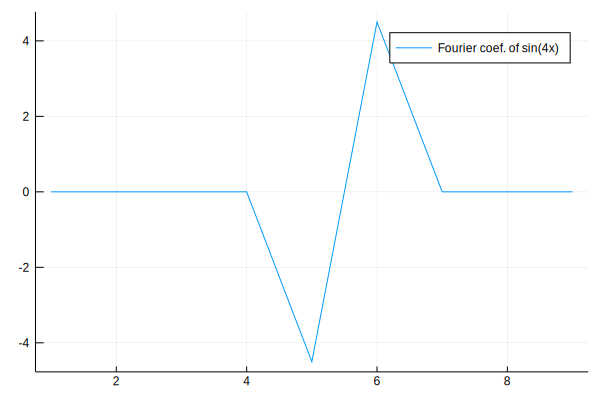

In [13]:
N=9;
x = range(0,stop=2*pi,length=N+1);
x = x[1:N];
f = sin.(4x);
f_hat = fft(f)
plot(imag(f_hat),label="Fourier coef. of sin(4x)")

未經過 truncating 會得到錯誤的係數。

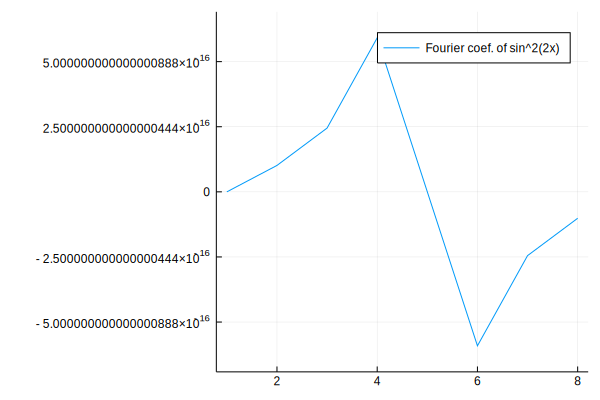

In [14]:
N=8;
x = range(0,stop=2*pi,length=N+1);
x = x[1:N];
f = sin.(2x);
g = cos.(2x);
fg = f.*g;
fg_hat = fft(fg)
plot(imag(fg_hat),label="Fourier coef. of sin^2(2x)")

我們考慮成對的傅立葉係數就好，$\hat{f}_{0}$ 與 $\hat{f}_{N/2}$ 先忽略。因此令 N' = N-2，與參考 N 為奇數時的推導，得到 $K < \frac{N'}{3} = (\frac{2}{3})(\frac{N'}{2})$。

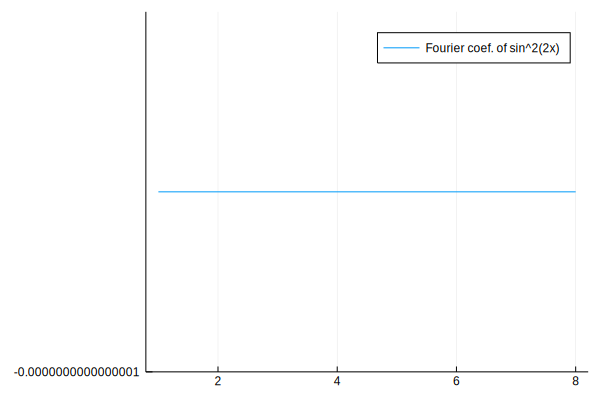

In [15]:
N=8;
x = range(0,stop=2*pi,length=N+1);
x = x[1:N];
f = sin.(2*x);
g = cos.(2*x);
f_hat = fft(f);
g_hat = fft(g);

# 1. 把 K 求出來，令新的 K 為小於舊的 K 的整數
K = (N-2)/3;

if K == floor(K)  
    K = Int(K) - 1;       # 若 K 算出來是整數，就取 K-1
else
    K = Int(floor(K));    # 若 K 算出來不是整數，就取 K 的整數部分
end

# 2. 只留下有符合範圍的部分 其餘設成 0
f_hat_new = append!(f_hat[1:K+1], zeros(1, N - 2*K-1));  # 保留 f_har_0, f_hat_1,..., f_hat_K
f_hat_new = append!(f_hat_new,f_hat[N-K+1:N])           # 保留 f_hat_-K, f_hat_-K+1,..., f_hat_-1

g_hat_new = append!(g_hat[1:K+1], zeros(1, N - 2*K-1));  # 保留 g_har_0, g_hat_1,..., g_hat_K
g_hat_new = append!(g_hat_new,g_hat[N-K+1:N]);           # 保留 g_hat_-K, g_hat_-K+1,..., g_hat_-1

# 3
f_new = ifft(f_hat_new)
g_new = ifft(g_hat_new)

# 4
h = f_new.*g_new;
h_hat = fft(h)

plot(imag(h_hat),label="Fourier coef. of sin^2(2x)")

再回來看為什麼結果是零，因為當 N = 8，K < 2，只有 $\hat{f}_{-1}, \hat{f}_{0}, \hat{f}_{1}$ 與 $\hat{g}_{-1}, \hat{g}_{0}, \hat{g}_{1}$ 的係數被留下，其餘設為 0。而 $h(x)$ 的傅立葉係數 $\hat{h}_{4}$ 須由 $\hat{f}_{2}$ 與 $\hat{g}_{2}$ 提供，$\hat{h}_{-4}$ 須由 $\hat{f}_{-2}$ 與 $\hat{g}_{-2}$ 提供。因此，最後答案為零函數。